# Data augmentation code


This is the code for the data augmentation used in the paper:

J. Sueiras, et al.: "Using Synthetic Character Database for Training Deep Learning Models Applied to Offline Handwritten Character Recognition", Proc. Intl. Conf. Intelligent Systems Design and Applications (ISDA), Springer, Porto (Portugal), 2016.   


In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.misc import imresize, imrotate, imsave 

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' 


path = '<yout_path_to_curated_database>/'

In [2]:
#Read characters only a-z and A-Z characters
#PENDING: special characters and digits

from os import listdir
from os.path import isfile, join

character_curated = [ord(c) for c in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ']
print([chr(i) for i in character_curated])

X = []
y = []
for i in character_curated:
    path_img = path + str(i) + '/'
    for file_name in [f for f in listdir(path_img) if isfile(join(path_img, f))]:
        img = cv2.imread(path_img + file_name, 0)
        #img = cv2.resize(img,(32, 32), interpolation = cv2.INTER_AREA)
        X += [img]
        y += [i]

X = np.array(X, dtype=np.uint8)
y = np.array(y, dtype=np.uint8)
print(X.shape)
print(y.shape)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
(46102, 64, 64)
(46102,)


In [3]:
#
#Select a subset of characters
#
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

def prepare_data_char_subset(X, y):
    '''
    Definition: Create train test data to model it
        - shuffle
        - separate train test
        - encode target to dummy vars
    Parameters:
        X: images[n_images, x_size, y_size]
        y: characters[n_images, 1]
        char_select: dictionary of characters selected
        augmentation_fuction
    
    usage:
        prepare_data_char_subset(X, y, set(['1','0']), augmentation_fuction = lambda: augmentate01(param1, param2=p2) )
        
    return:
        X_train, y_train, X_test, y_test, labels_dictionary
    '''
    X_select = X
    y_select = y

    #Shuffle
    X_select, y_select = shuffle(X_select, y_select, random_state=0)
    
    
    #Separate train test
    X_train, X_test, y_train, y_test = train_test_split(X_select, y_select, test_size=0.20, random_state=42)
    print(X_train.shape)
    X_train = np.reshape(X_train,  (X_train.shape[0],1,X_train.shape[1],X_train.shape[2]))
    X_test = np.reshape(X_test,  (X_test.shape[0],1,X_test.shape[1],X_test.shape[2]))
    
    print('Train shape: ',X_train.shape, y_train.shape)
    print('Test shape: ',X_test.shape, y_test.shape)
    print('Num classes: ', len(set(y_train)))
    print('Classes: ', set(y_train))
    
    return X_train, y_train, X_test, y_test


In [4]:
#Separate train test data
X_train, y_train, X_test, y_test = prepare_data_char_subset(X, y)

print(X_train.shape, X_test.shape)

(36881, 64, 64)
Train shape:  (36881, 1, 64, 64) (36881,)
Test shape:  (9221, 1, 64, 64) (9221,)
Num classes:  52
Classes:  set([65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])
(36881, 1, 64, 64) (9221, 1, 64, 64)


## Generate new data
    - New characters concatenating in the border of the character the start and/or end of other characters
    - new characters moving up /down characters (rescale and place in the selected positions). Classes:
        - Medium or high or low: a, c, e, i, m, n, o, r, s, u, v, w, x, z
        - Low - Medium: g, j, p, q, y 
        - Medium-High: b, d, f, h, k, l, t
    - Two ways to concatenate: with separation or withow separation (the border are aprox 4pixels)  
    - concatenate original characters with original characters and moved characters with moved characters 
  

In [5]:
def move_characters(X, y):
    X_moved=[]
    y_moved=[]
    
    for i,y_value in enumerate(y):
        y_char = chr(y_value)
        if y_char in ['a', 'c', 'e', 'i', 'm', 'n', 'o', 'r', 's', 'u', 'v', 'w', 'x', 'z']:
            #Resize to 40x40 and place botton, medium and top 
            img1 = imresize(X[i,0,:,:],(46,46))
            
            img_center = np.zeros((64,64))
            img_center[9:55, 9:55] = img1 
            X_moved += [img_center]
            y_moved += [y_value]
            
            img_top = np.zeros((64,64))
            img_top[:46, 9:55] = img1 
            X_moved += [img_top]
            y_moved += [y_value]

            img_botton = np.zeros((64,64))
            img_botton[18:, 9:55] = img1 
            X_moved += [img_botton]
            y_moved += [y_value]

        elif y_char in ['g', 'j', 'p', 'q', 'y']:
            #Resize to 52x52 and place botton
            img1 = imresize(X[i,0,:,:],(46,46))
            img_botton = np.zeros((64,64))
            img_botton[18:, 9:55] = img1 
            X_moved += [img_botton]
            y_moved += [y_value]

        elif y_char in ['b', 'd', 'f', 'h', 'k', 'l', 't', 'A', 'B', 'C', 'D', 'E',
                        'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 
                        'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']:
            #Resize to 52x52 and place on top
            img1 = imresize(X[i,0,:,:],(46,46))            
            img_top = np.zeros((64,64))
            img_top[:46, 9:55] = img1 
            X_moved += [img_top]
            y_moved += [y_value]

    X_moved = np.array(X_moved, dtype=np.float16)
    y_moved = np.array(y_moved)
    X_moved = np.reshape(X_moved, (X_moved.shape[0], 1, X_moved.shape[1], X_moved.shape[2]) )
    return X_moved, y_moved



(174, 1, 64, 64) (174,)


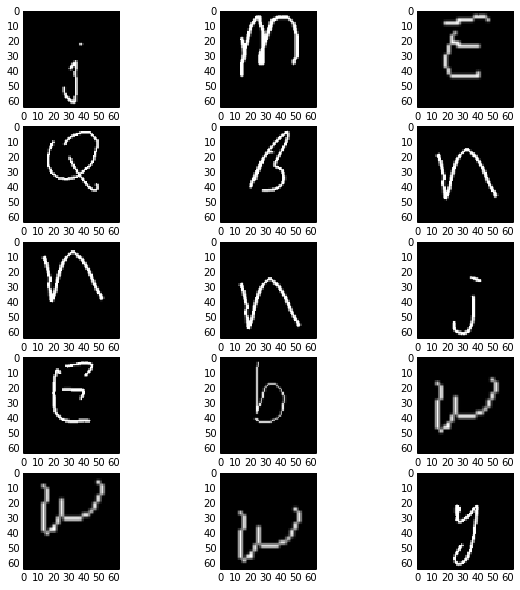

In [6]:
#Test and show
X_train_moved, y_train_moved = move_characters(X_train[4347:4449], y_train[4347:4449])
print(X_train_moved.shape, y_train_moved.shape)

fig = plt.figure()
pos_ini=0
n_chars=15
for i,index in enumerate(xrange(pos_ini,pos_ini+n_chars)):           
    fig.add_subplot(n_chars/3,3,i)
    plt.imshow(X_train_moved[i,0,:,:])



In [7]:
#Count cases by target value
from collections import Counter

c = Counter(y_train)
d_num_cases = dict(c.most_common())
print(d_num_cases)

{65: 749, 66: 412, 67: 515, 68: 449, 69: 946, 70: 384, 71: 370, 72: 445, 73: 720, 74: 376, 75: 378, 76: 565, 77: 397, 78: 548, 79: 912, 80: 482, 81: 332, 82: 670, 83: 660, 84: 593, 85: 353, 86: 323, 87: 415, 88: 299, 89: 367, 90: 359, 97: 1783, 98: 493, 99: 702, 100: 857, 101: 2366, 102: 486, 103: 622, 104: 796, 105: 1615, 106: 329, 107: 453, 108: 1140, 109: 697, 110: 1533, 111: 1657, 112: 627, 113: 346, 114: 1367, 115: 1223, 116: 1419, 117: 1052, 118: 454, 119: 551, 120: 373, 121: 537, 122: 384}


In [8]:
X_train_moved, y_train_moved = move_characters(X_train, y_train)
print(X_train_moved.shape, y_train_moved.shape)

X_test_moved, y_test_moved = move_characters(X_test, y_test)
print(X_test_moved.shape, y_test_moved.shape)

(68395, 1, 64, 64) (68395,)
(17139, 1, 64, 64) (17139,)


## Add borders
    - Include in the border of each character the start/end of other letters 1 and 3 pixels
    - Create borders: select random characters and identify an cut borders of 2 and 4 pixels in each side
    - For each character select a random border and generate new character. Dont move the position of the original character
    - For each character identify how many need to generate to obtain a balanced sample of 1000


In [9]:
#create 64x8 borders left and rigth
def obtain_borders(img, treshold=0.):
    #Identify border of the letter
    border_left = img[:,:8]
    left_position = 0
    for i in xrange(0,56,1):
        if np.max(img[:,i]) > treshold:
            left_position = i
            break
    rigth_position = 64
    border_rigth = img[:,56:]
    for i in xrange(63,8,-1):
        if np.max(img[:,i]) > treshold:
            rigth_position = i
            break
    return img[:,left_position:left_position+8], img[:,rigth_position-8:rigth_position], img[:,left_position:rigth_position]


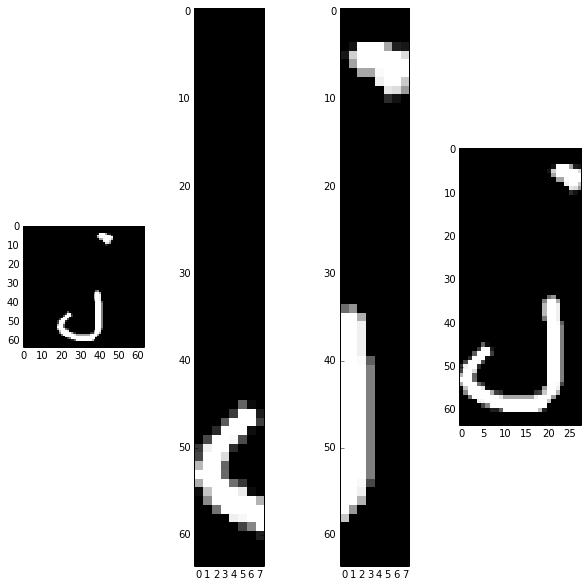

In [10]:
# Test
border_left, border_rigth, char_adjusted = obtain_borders(X_train[0,0,:,:])

f = plt.figure()

a = f.add_subplot(1,4,1)
plt.imshow(X_train[0,0,:,:])

a = f.add_subplot(1,4,2)
plt.imshow(border_left)

a = f.add_subplot(1,4,3)
plt.imshow(border_rigth)

a = f.add_subplot(1,4,4)
plt.imshow(char_adjusted)



In [11]:
train_left_borders = []
train_rigth_borders = []
train_img_no_borders = []
for i,y_value in enumerate(y_train):
    l, r, c = obtain_borders(X_train[i,0,:,:], treshold=0.)
    train_left_borders += [l]
    train_rigth_borders += [r]
    train_img_no_borders += [c]
train_left_borders = np.array(train_left_borders)
train_rigth_borders = np.array(train_rigth_borders)

    
test_left_borders = []
test_rigth_borders = []
test_img_no_borders = []
for i,y_value in enumerate(y_test):
    l, r, c = obtain_borders(X_test[i,0,:,:], treshold=0.)
    test_left_borders += [l]
    test_rigth_borders += [r]
    test_img_no_borders += [c]
test_left_borders = np.array(test_left_borders)
test_rigth_borders = np.array(test_rigth_borders)


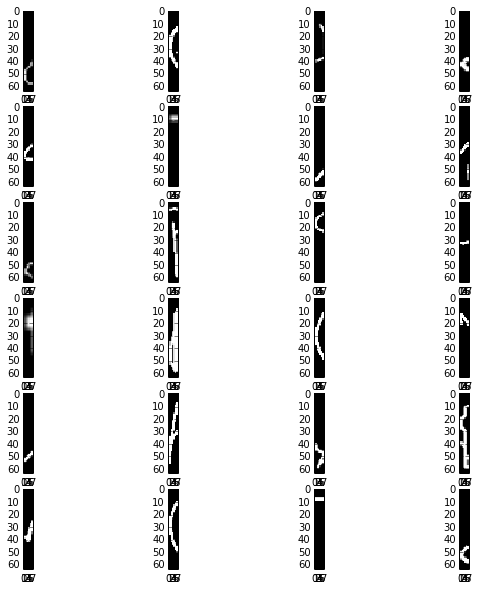

In [12]:
# Example of results
f = plt.figure()
for i in xrange(24):
    a = f.add_subplot(6,4,i)
    plt.imshow(train_left_borders[i,:,:])


## Join the borders to the original images

In [15]:
import random

X_trn_borders_left = []
X_trn_borders_rigth = []
y_trn_borders_left = []
y_trn_borders_rigth = []
def generate_borders_images(X,y):
    X_left = []
    y_left = []
    X_rigth = []
    y_rigth = []
    for i,y_value in enumerate(y):
        y_char = y_value
        #n_images = int(10000 / d_num_cases[y_char]) # balanced sample
        n_images = int(30000 / (d_num_cases[y_char])) # Reduce by 2 the balanced sample to reduce sample
        
        for j in xrange(n_images/2): # two images each iteration
            n_borders =  int(random.uniform(0,X.shape[0]))
            img_left = np.copy(X[i,0,:,:])
            img_left[:,:5] = train_rigth_borders[n_borders,:,-5:] #put the rigth side of the rigth border
            X_left += [img_left]
            y_left += [y_value]
            
            img_rigth = np.copy(X[i,0,:,:])
            img_rigth[:,-5:] = train_left_borders[n_borders,:,:5] #put the left side of the left border
            X_rigth += [img_rigth]
            y_rigth += [y_value]
            
    X_left  = np.array(X_left, dtype=np.float16)
    X_left  = np.reshape(X_left, (X_left.shape[0], 1, X_left.shape[1], X_left.shape[2]) )
    y_left  = np.array(y_left)
    X_rigth = np.array(X_rigth, dtype=np.float16)
    X_rigth = np.reshape(X_rigth, (X_rigth.shape[0], 1, X_rigth.shape[1], X_rigth.shape[2]) )
    y_rigth = np.array(y_rigth)
    return X_left, y_left, X_rigth, y_rigth



(264, 1, 64, 64) (264,) (264, 1, 64, 64) (264,)


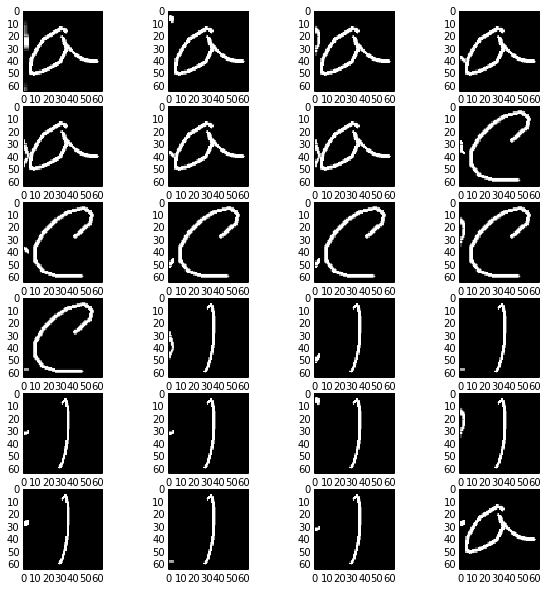

In [16]:
# Test
X_train_left, y_train_left, X_train_rigth, y_train_rigth = generate_borders_images(X_train[300:315],y_train[300:315])
    
print( X_train_left.shape, y_train_left.shape, X_train_rigth.shape, y_train_rigth.shape)

f = plt.figure()
for i in xrange(24):
    a = f.add_subplot(6,4,i)
    plt.imshow(X_train_left[i,0,:,:])


In [17]:
# Join borders to train and test data

X_train_left, y_train_left, X_train_rigth, y_train_rigth = generate_borders_images(X_train, y_train)
print( X_train_left.shape, y_train_left.shape, X_train_rigth.shape, y_train_rigth.shape)
   
X_test_left, y_test_left, X_test_rigth, y_test_rigth = generate_borders_images(X_test, y_test)
print( X_test_left.shape, y_test_left.shape, X_test_rigth.shape, y_test_rigth.shape)

(763398, 1, 64, 64) (763398,) (763398, 1, 64, 64) (763398,)
(192459, 1, 64, 64) (192459,) (192459, 1, 64, 64) (192459,)


In [18]:
#Combine all sources

X_train_aug = np.concatenate((X_train, X_train_moved, X_train_left, X_train_rigth),axis=0)
y_train_aug = np.concatenate((y_train, y_train_moved, y_train_left, y_train_rigth),axis=0)

X_test_aug = np.concatenate((X_test, X_test_moved, X_test_left, X_test_rigth),axis=0)
y_test_aug = np.concatenate((y_test, y_test_moved, y_test_left, y_test_rigth),axis=0)

print(X_train_aug.shape, y_train_aug.shape, X_train_aug.shape, y_train_aug.shape)
print(X_test_aug.shape, y_test_aug.shape, X_test_aug.shape, y_test_aug.shape)

(1632072, 1, 64, 64) (1632072,) (1632072, 1, 64, 64) (1632072,)
(411278, 1, 64, 64) (411278,) (411278, 1, 64, 64) (411278,)


In [19]:
#Shuffle train data
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=0)


In [20]:
# standarize 
X_train_aug = (X_train_aug -128.)/ 255.
X_test_aug  = (X_test_aug -128.)/ 255.
    
    


S


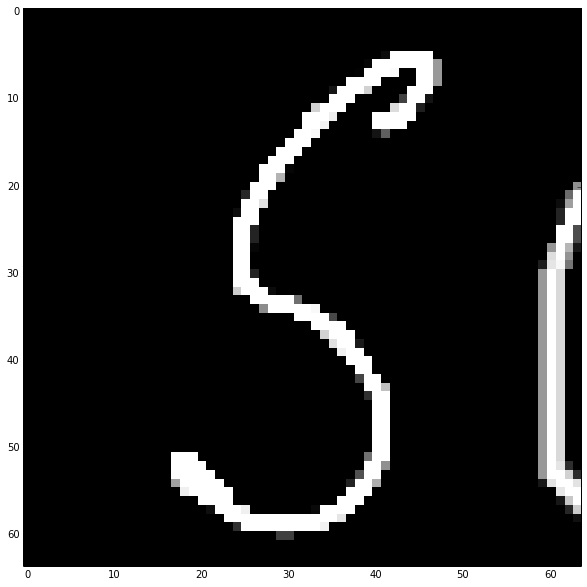

In [21]:
#Check data
i=13345
print(chr(y_train_aug[i]))
plt.imshow(X_train_aug[i,0,:,:])

In [ ]:
#Save data to hdf5
import h5py

hdf5_f = h5py.File(path + "characters_upcase_lowcase_64x64.hdf5",mode='a')

if "X_train_aug" in hdf5_f:
    del hdf5_f["X_train_aug"]
hdf5_f.create_dataset("X_train_aug", data = X_train_aug) 

if "y_train_aug" in hdf5_f:
    del hdf5_f["y_train_aug"]
hdf5_f.create_dataset("y_train_aug", data = y_train_aug)

if "X_test_aug" in hdf5_f:
    del hdf5_f["X_test_aug"]
hdf5_f.create_dataset("X_test_aug", data = X_test_aug) 

if "y_test_aug" in hdf5_f:
    del hdf5_f["y_test_aug"]
hdf5_f.create_dataset("y_test_aug", data = y_test_aug)

hdf5_f.close() 

In [ ]:
#Example of cade to load the data generated from hdf5
import h5py

hdf5_f = h5py.File(path + "characters_upcase_lowcase_64x64.hdf5", mode='r')

X = hdf5_f["X_train_aug"]
y = hdf5_f["y_train_aug"]
print X.shape, y.shape
X_train_aug = np.copy(X)
y_train_aug = np.copy(y)

X = hdf5_f["X_test_aug"]
y = hdf5_f["y_test_aug"]
print X.shape, y.shape
X_test_aug = np.copy(X)
y_test_aug = np.copy(y)


hdf5_f.close()